In [1]:
import statsmodels.api as sm
import statsmodels.stats.diagnostic

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from statsmodels.tsa.api import VAR

def rmse(pred, actual):
    return np.sqrt(((pred - actual) ** 2).mean())


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic



In [2]:
# LOAD DATA

data_path = "../Year data P//"

df = pd.read_csv(data_path + 'Russia//Russia Data.csv')
df = df.loc[df['year'] >= 1991]
df = df.drop(['countrycode','country','currency_unit','year'],axis = 1)
year = pd.period_range('1991', '2019', freq='Y')
df.index = year


In [3]:
from sklearn.preprocessing import MinMaxScaler
Xscaler =MinMaxScaler()
df.iloc[:,0:-1]=Xscaler.fit_transform(df.values[:,0:-1])

In [4]:
df_train = df['1990':'2009']
df_test = df['2010':'2019']

In [5]:
for i in range(0,20):
    adfResult = sm.tsa.stattools.adfuller(df_train.iloc[:,i])
    if adfResult[1]<0.05:
        print(i)
        print(df.columns[i])
        print("stable")
    else:
        print(i)
        print(df.columns[i])
        print("UNstable")

0
GDP
UNstable
1
net population growth
UNstable
2
CPI
stable
3
employment rate
UNstable
4
labsh
stable
5
xr
UNstable
6
pl_gdpo
UNstable
7
csh_c
UNstable
8
csh_i
stable
9
csh_g
UNstable
10
csh_x
stable
11
csh_m
stable
12
csh_r
stable
13
pl_c
UNstable
14
pl_i
stable
15
pl_g
stable
16
pl_x
stable
17
pl_m
stable
18
pl_n
stable
19
pl_k
stable


In [6]:
df.iloc[:,0] = df.iloc[:,0].diff(1)
df.iloc[:,1] = df.iloc[:,1].diff(1)
df.iloc[:,3] = df.iloc[:,3].diff(1)
df.iloc[:,5] = df.iloc[:,5].diff(1)
df.iloc[:,6] = df.iloc[:,6].diff(1)
df.iloc[:,7] = df.iloc[:,7].diff(1)
df.iloc[:,9] = df.iloc[:,9].diff(1)
df.iloc[:,13] = df.iloc[:,13].diff(1)

df_train = df['1990':'2009']
df_test = df['2010':'2019']

In [7]:
for i in range(0,20):
    adfResult = sm.tsa.stattools.adfuller(df_train.iloc[1:,i])
    if adfResult[1]<0.05:
        print(i)
        print(df.columns[i])
        print("stable")
    else:
        print(i)
        print(df.columns[i])
        print("UNstable")

0
GDP
UNstable
1
net population growth
UNstable
2
CPI
stable
3
employment rate
stable
4
labsh
stable
5
xr
UNstable
6
pl_gdpo
stable
7
csh_c
UNstable
8
csh_i
stable
9
csh_g
UNstable
10
csh_x
stable
11
csh_m
UNstable
12
csh_r
stable
13
pl_c
stable
14
pl_i
UNstable
15
pl_g
UNstable
16
pl_x
stable
17
pl_m
stable
18
pl_n
stable
19
pl_k
stable


In [8]:
for i in range(0,20):
    result = sm.tsa.stattools.coint(df.iloc[1:,-1],df.iloc[1:,i])
    if result[1]<0.05:
        print(i)
        print(df.columns[i])
        print("coint")
    else:
        print(i)
        print(df.columns[i])
        print("not coint")

0
GDP
not coint
1
net population growth
not coint
2
CPI
coint
3
employment rate
not coint
4
labsh
not coint
5
xr
not coint
6
pl_gdpo
not coint
7
csh_c
not coint
8
csh_i
coint
9
csh_g
coint
10
csh_x
coint
11
csh_m
not coint
12
csh_r
coint
13
pl_c
not coint
14
pl_i
not coint
15
pl_g
not coint
16
pl_x
not coint
17
pl_m
not coint
18
pl_n
not coint
19
pl_k
not coint


In [9]:
df_train = df.iloc[1:,[0,3,7,8,9,10,12]]['1992':'2009']
df_test = df.iloc[1:,[0,3,7,8,9,10,12]]['2010':'2019']

In [10]:
### FIND BEST VAR ORDER with AIC ###
AIC = {}
best_aic, best_order = np.inf, 0
lagsToTest = 2
for i in range(1, lagsToTest):
    model = VAR(df_train.values)
    model_result = model.fit(i)
    AIC[i] = model_result.aic

    if AIC[i] < best_aic:
        best_aic = AIC[i]
        best_order = i

print('BEST ORDER:', best_order, 'BEST AIC:', best_aic)

BEST ORDER: 1 BEST AIC: -29.78295456541661


In [11]:
### FIT FINAL VAR WITH LAG CORRESPONTING TO THE BEST AIC ###
var = VAR(df_train)
var_result = var.fit(maxlags=best_order)
print("var_result.aic: ", var_result.aic)

var_result.aic:  -29.78295456541661


In [12]:
print(len(df_test.values[-best_order:]))

forecast_input = df_test.values[-best_order:]

# Forecast
fc = var_result.forecast(y = forecast_input, steps=5)
df_forecast = pd.DataFrame(fc, index=pd.period_range(start = '2020',end = '2024',freq = 'Y'), columns=df_test.columns)
#print(df_forecast)

1


<AxesSubplot:>

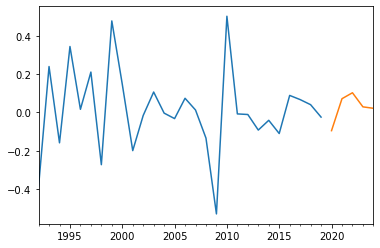

In [13]:
plt.figure()
df.iloc[1:,0].plot()
df_forecast.iloc[:,0].plot()

In [14]:
predict_Test = var_result.forecast(y = df_train.values, steps=10)
rmse(predict_Test[:,0],df_test.iloc[:,0].values)

0.12272114734469154

0.3371546564728945


<AxesSubplot:>

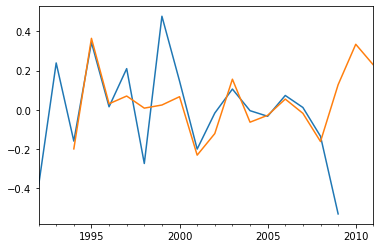

In [15]:
fitted_value = np.zeros((18,df_train.shape[1]))
for i in range(0,18,2):
    a = var_result.forecast(y = df_train.iloc[i:i+2,:].values, steps=2)
    fitted_value[i:i+2,:] = a

fitted_value = pd.DataFrame(fitted_value, index=pd.period_range(start = '1994',end = '2011',freq = 'Y'), columns=df_train.columns)
#print(df_forecast)

print(rmse(fitted_value.iloc[:-1,0],df_train.iloc[1:,0].values))
plt.figure()
df_train.iloc[:,0].plot()
fitted_value.iloc[:,0].plot()

In [16]:
fitted_value.shape

(18, 7)

<AxesSubplot:>

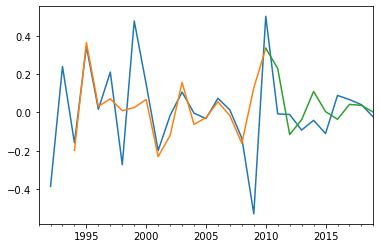

In [17]:
predict_Test = pd.DataFrame(predict_Test, index=pd.period_range(start = '2010',end = '2019',freq = 'Y'))
plt.figure()
df.iloc[:,0].plot()
fitted_value.iloc[:-1,0].plot()
predict_Test.iloc[:,0].plot()